# Trabajo Final ViT

Integrantes:
- Kevin Guerra Huamán
- Marco Joel Isidro
- Víctor David Silva

Tema:
- Generación de captions (texto a partir de imagen)

> INFO: El presente notebook se ejecuto en una seción de google colab con una gráfica A100 el día 01/12/2024. Puede llegar a ser necesario que para algunas visualizaciones se deba visualizar el mismo en dicho entorno.

# Preparación del entorno en colab

Se instalan las librerías necesarias para la realización del trabajo y las importaciones generales a utiliar durante el notebook.

In [1]:
! pip install transformers pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.8 MB/s eta 0:00:00


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import requests
import pandas as pd
import json
import gdown

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, Trainer, TrainingArguments, TrainerCallback

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# EDA

In [4]:
from zipfile import ZipFile as ZipFile_extrac
from pathlib import Path

from nltk.tokenize import word_tokenize
from skimage.io import imread
from nltk.corpus import stopwords

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Carga de los datos

In [ ]:
# Carga de los datos de Flickr30k desde Kaggle
! kaggle datasets download hsankesara/flickr-image-dataset

file = "flickr-image-dataset.zip"
data_dir = Path('/content/flickr30k_images/')
train_dir = data_dir / 'flickr30k_images'
caption_dir = data_dir / 'results.csv'

with ZipFile_extrac(file, 'r') as zip_extrac:
    zip_extrac.extractall();

captions = pd.read_csv(caption_dir, sep="|", names=["image_name", "comment_number", "comment"], skiprows=1)
print(f"Total registros: {len(captions)}")

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.15G/8.16G [00:56<00:00, 160MB/s]
100% 8.16G/8.16G [00:56<00:00, 156MB/s]
Total registros: 158915


In [ ]:
captions.describe()

,image_name,comment_number,comment
count,158915,158915,158914
unique,31783,6,158438
top,998845445.jpg,0,Two dogs playing in the snow .
freq,5,31783,7


In [ ]:
captions.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


## Correcciones de formato

El dataset cuenta 3 columnas, donde se puede encontrar el nombre de la imágen, el número de comentario correspondiente a la imagen y el momentario correspondiente.

Al convertir el formato de la columna ```comment_number``` a enteros se encontraron irregularidades. A continuación se arreglan las mismas.

In [ ]:
row = captions[captions['comment_number'] == ' 4   A dog runs across the grass .']
row

,image_name,comment_number,comment
19999,2199200615.jpg,4 A dog runs across the grass .,NaN


In [ ]:
fila_problematica = captions['comment_number'].str.contains(' 4   A dog runs across the grass .')

captions.loc[fila_problematica, 'comment_number'] = ' 4'
captions.loc[fila_problematica, 'comment'] = 'A dog runs across the grass .'

captions['image_name'] = captions['image_name'].astype(str)
captions['comment'] = captions['comment'].astype(str)
captions['comment_number'] = captions['comment_number'].astype(int)

## Análisis de los datos

In [ ]:
# Cantidad total de imágenes y captions por imagen
num_images = captions["image_name"].nunique()
captions_per_image = captions.groupby("image_name").size()

print(f"Cantidad total de imágenes: {num_images}")
print(f"Captions por imagen: {captions_per_image.unique()}")

Cantidad total de imágenes: 31783
Captions por imagen: [5]


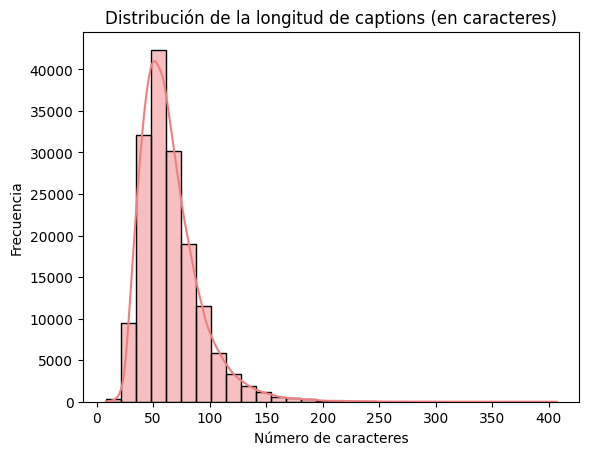

In [ ]:
# Visualizar la distribución de la longitud de captions (en caracteres)
captions["caption_length"] = captions["comment"].apply(len)
sns.histplot(captions["caption_length"], bins=30, kde=True, color="lightcoral")
plt.title("Distribución de la longitud de captions (en caracteres)")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

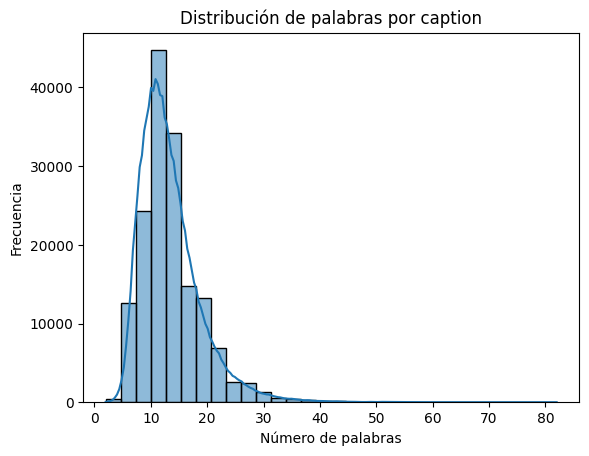

In [ ]:
# Visualizar la distribución de palabras por caption
captions["word_count"] = captions["comment"].apply(lambda x: len(word_tokenize(x)))
sns.histplot(captions["word_count"], bins=30, kde=True)
plt.title("Distribución de palabras por caption")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

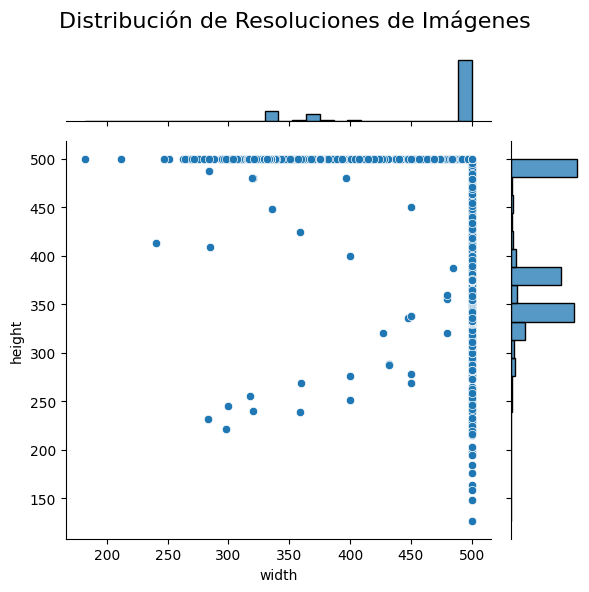

In [ ]:
# Visualizar la distribución de resoluciones de las imágenes
sample_images = os.listdir(train_dir)[:5000]

image_resolutions = []
for image_name in sample_images:
    image_path = os.path.join(train_dir, image_name)
    image = imread(image_path)
    image_resolutions.append((image_name, image.shape[0], image.shape[1]))

image_res_df = pd.DataFrame(image_resolutions, columns=["image_name", "height", "width"])

jointplot = sns.jointplot(data=image_res_df, x="width", y="height")
jointplot.fig.suptitle("Distribución de Resoluciones de Imágenes", fontsize=16)
jointplot.fig.tight_layout()
jointplot.fig.subplots_adjust(top=0.9)

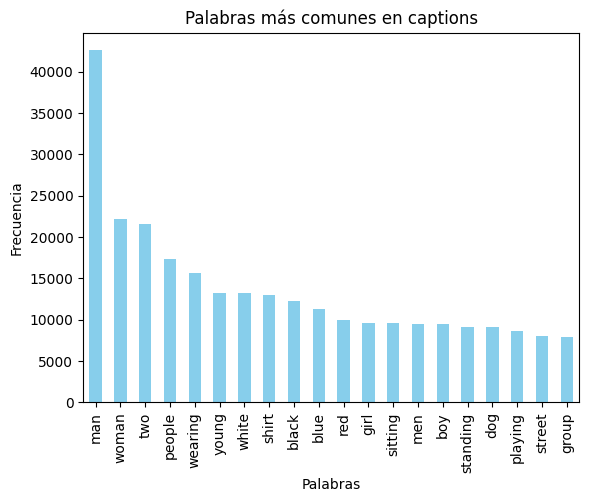

In [ ]:
# Visualizar la distribución de las palabras más comunes en captions
stop_words = set(stopwords.words('english'))
all_words = [word for comment in captions["comment"] for word in word_tokenize(comment.lower()) if word.isalnum() and word not in stop_words]
word_freq = pd.Series(all_words).value_counts()

word_freq.head(20).plot(kind="bar", color="skyblue")
plt.title("Palabras más comunes en captions")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
def plot_vertical_images_with_captions(image_names, captions_df, train_dir):
    """
    Muestra imágenes con su caption

    Args:
        image_names: Nombre de las imágenes a mostrar.
        captions_df: Captions del dataframe.
        train_dir: Ruta a las imágenes.
    """
    num_images = len(image_names)
    plt.figure(figsize=(4, num_images * 3))

    for i, image_name in enumerate(image_names):
        img_path = os.path.join(train_dir, image_name)
        img = imread(img_path)

        caption_image = captions_df[captions_df["image_name"] == image_name]["comment"].tolist()[0]

        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(caption_image, fontsize=8, loc='center')

    plt.tight_layout()
    plt.show()

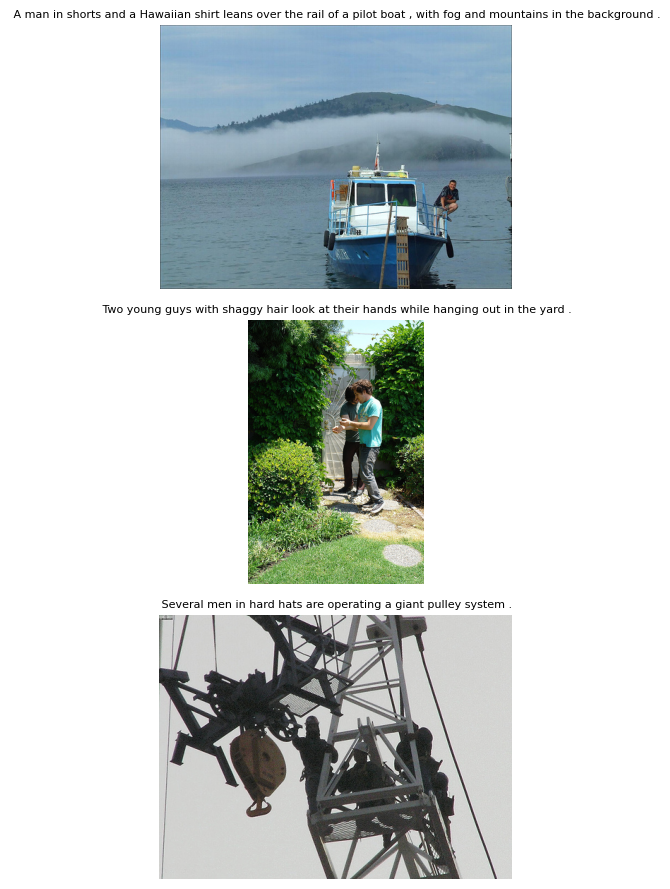

In [ ]:
example_images = captions["image_name"].value_counts().head(3).index
plot_vertical_images_with_captions(example_images, captions, train_dir)

# Preprocesamiento y armado de datasets

In [ ]:
captions["comment"] = captions["comment"].apply(lambda x: "[START] "+x.lower().replace('[^\w\s]','')+" [END]")

In [ ]:
filtered_captions = captions[captions['comment_number'] == 0].reset_index(drop=True)

print(f"Original dataset size: {len(captions)}")
print(f"Filtered dataset size: {len(filtered_captions)}")

Original dataset size: 158915
Filtered dataset size: 31783


In [ ]:
filtered_captions["image_name"] = filtered_captions["image_name"].apply(lambda x: os.path.join(train_dir,x))

In [ ]:
filtered_captions = filtered_captions.drop(['comment_number', 'word_count', 'caption_length'], axis=1)

In [ ]:
filtered_captions.head()

,image_name,comment
0,/content/flickr30k_images/flickr30k_images/100...,[START] two young guys with shaggy hair look ...
1,/content/flickr30k_images/flickr30k_images/100...,[START] several men in hard hats are operatin...
2,/content/flickr30k_images/flickr30k_images/100...,[START] a child in a pink dress is climbing u...
3,/content/flickr30k_images/flickr30k_images/100...,[START] someone in a blue shirt and hat is st...
4,/content/flickr30k_images/flickr30k_images/100...,"[START] two men , one in a gray shirt , one i..."


A continuación se realizan reducciones en el dataset debido a limitaciones de memoria durante el entrenamiento y validación del modelo.

In [ ]:
sample_size = int(0.40 * len(filtered_captions))
random_sample = filtered_captions.sample(n=sample_size, random_state=42)

train_df, temp_df = train_test_split(random_sample, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Tamaño de entrenamiento: {len(train_df)}")
print(f"Tamaño de validación: {len(val_df)}")
print(f"Tamaño de test: {len(test_df)}")

Tamaño de entrenamiento: 10170
Tamaño de validación: 1271
Tamaño de test: 1272


# Entrenamiento

## Definicion de métricas a utilizar

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pycocoevalcap.cider.cider import Cider
import gc

In [ ]:
def compute_metrics(eval_pred):
    """
    Calcula las métricas

    Args:
        eval_pred: Predicciones del modelo.

    Returns:
        Un diccionario con las métricas BLEU y CIDEr.
    """
    with torch.no_grad():
        logits, labels = eval_pred

        if isinstance(logits, tuple):
            logits = logits[0]

        # se reducen logits a IDs de tokens
        predicted_ids = np.argmax(logits, axis=-1)  # De (batch_size, sequence_length, vocab_size) a (batch_size, sequence_length)
        labels = labels.squeeze()

        generated_captions = [processor.decode(pred, skip_special_tokens=True) for pred in predicted_ids]
        reference_captions = [processor.decode(label, skip_special_tokens=True) for label in labels]

        # Calcular BLEU
        smooth_fn = SmoothingFunction().method1
        bleu_scores = [
            sentence_bleu([ref.split()], gen.split(), smoothing_function=smooth_fn)
            for ref, gen in zip(reference_captions, generated_captions)
        ]
        avg_bleu = np.mean(bleu_scores)

        # Calcular CIDEr
        cider = Cider()
        references_dict = {idx: [ref] for idx, ref in enumerate(reference_captions)}
        generated_dict = {idx: [gen] for idx, gen in enumerate(generated_captions)}
        cider_score, _ = cider.compute_score(references_dict, generated_dict)

        del logits, labels, predicted_ids, generated_captions, reference_captions, references_dict, generated_dict
        gc.collect()

        return {
            "BLEU": avg_bleu,
            "CIDEr": cider_score,
        }


## Carga de modelo base

In [ ]:
def print_trainable_parameters(model):
    """
    Muestra el números de parámetros entrenables del modelo.

    Args:
        model: El modelo para el cual se mostrarán los parámetros.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
print_trainable_parameters(model)

trainable params: 247414076 || all params: 247414076 || trainable%: 100.0


In [ ]:
def generate_caption(model, processor, raw_image, text=None, max_new_tokens=32, device="cuda"):
    """
    Genera una leyenda para una imagen usando un modelo dado y opcionalmente un texto inicial.

    Args:
        model: El modelo de generación.
        processor: El procesador del modelo.
        raw_image: La imagen en bruto.
        text (str, opcional): El texto inicial para la generación. Si es None, no se usa texto inicial.
        max_new_tokens (int): Máxima cantidad de nuevos tokens a generar.

    Returns:
        str: Leyenda generada.
    """
    if text:
        inputs = processor(raw_image, text, return_tensors="pt").to(device, torch.float16)
    else:
        inputs = processor(raw_image, return_tensors="pt").to(device, torch.float16)

    out = model.generate(**inputs, max_new_tokens=max_new_tokens)

    return processor.decode(out[0], skip_special_tokens=True)

Caption 1: a photography of a woman and her dog on the beach
Caption 2: a photo of a woman and her dog on the beach
Caption 3: a woman sitting on the beach with her dog


Imagen para test de modelo original:


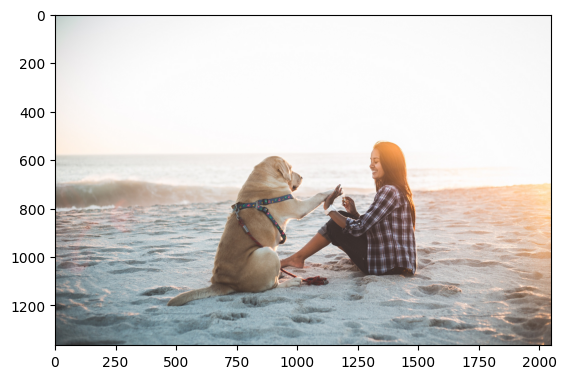

In [ ]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

captions = [
    generate_caption(model, processor, raw_image, text="a photography of"),
    generate_caption(model, processor, raw_image, text="A photo of"),
    generate_caption(model, processor, raw_image)
]

for i, caption in enumerate(captions, 1):
    print(f"Caption {i}: {caption}")

print("\n\nImagen para test de modelo original:")
plt.imshow(raw_image)

## Definicion de clase Flickr30kDataset y obtención de métrica base

In [ ]:
class Flickr30kDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_name']
        caption = self.data.iloc[idx]['comment']

        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length", truncation=True, max_length=32)

        pixel_values = inputs['pixel_values'].squeeze()  # Dimensiones (C, H, W)
        input_ids = inputs['input_ids'].squeeze()  # IDs de entrada
        attention_mask = inputs['attention_mask'].squeeze()  # Máscara de atención

        return {
            'pixel_values': pixel_values,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_ids.clone()
        }

In [ ]:
val_dataset = Flickr30kDataset(val_df, processor)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    run_name="model_base",
    per_device_eval_batch_size=8,
    report_to="none",
    fp16=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset,
    processing_class=processor,
    compute_metrics=compute_metrics
)

eval_results = trainer.evaluate()

print("\nRESULTADOS DE VALIDACIÓN:\n")
print(json.dumps(eval_results, indent=4))

with open('./results/val_base_results.json', 'w') as f:
    json.dump(eval_results, f)


RESULTADOS DE VALIDACIÓN:

{
    "eval_loss": 5.801806449890137,
    "eval_model_preparation_time": 0.0075,
    "eval_BLEU": 0.04015288433980999,
    "eval_CIDEr": 0.4285219921623448,
    "eval_runtime": 33.5007,
    "eval_samples_per_second": 37.939,
    "eval_steps_per_second": 4.746
}


Si utilizaramos nuestro dataset con el modelo base, las métricas principales que utilizamos nos darían:
* BLEU: 0.0401
* CIDEr: 0.4285

## Fine-Tuning

In [ ]:
train_dataset = Flickr30kDataset(train_df, processor)
val_dataset = Flickr30kDataset(val_df, processor)
test_dataset = Flickr30kDataset(test_df, processor)

In [ ]:
class FreeMemoryCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="CIDEr",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    num_train_epochs=5,
    warmup_steps=500,
    weight_decay=0.1, # Se aumento de 0.01 a 0.1 por problemas de overfiting
    logging_steps=250,
    report_to="none",
    fp16=True,
    run_name="model_fine-tuning",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=processor,
    compute_metrics=compute_metrics, #se pasa el calculo de métricas definido
    callbacks=[FreeMemoryCallback()] #se borra el cache de memoria al terminar de evaluar
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Cider
0,1.694000,1.687130,0.227656,1.134595
2,0.909600,1.720834,0.231456,1.201127
4,0.278600,1.976892,0.223066,1.169873


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=12710, training_loss=0.9812333296829091, metrics={'train_runtime': 4121.724, 'train_samples_per_second': 12.337, 'train_steps_per_second': 3.084, 'total_flos': 3.016965847912022e+19, 'train_loss': 0.9812333296829091, 'epoch': 4.999016715830875})

In [ ]:
os.makedirs("./results/modelo", exist_ok=True)

# Guardar los archivos del modelo y logs
trainer.save_model("./results/modelo")
processor.save_pretrained("./results/modelo")

training_logs = trainer.state.log_history
with open('./results/training_loss.json', 'w') as f:
    json.dump(training_logs, f)

In [ ]:
# Evaluar el modelo entrenado
test_results = trainer.evaluate(test_dataset)

print("\nRESULTADOS EN TEST:\n")
print(json.dumps(test_results, indent=4))

with open('./results/test_results.json', 'w') as f:
    json.dump(test_results, f)


RESULTADOS EN TEST:

{
    "eval_loss": 1.7914985418319702,
    "eval_BLEU": 0.23344534346027038,
    "eval_CIDEr": 1.2231331491042434,
    "eval_runtime": 49.6017,
    "eval_samples_per_second": 25.644,
    "eval_steps_per_second": 6.411,
    "epoch": 4.999016715830875
}


# Análisis de resultados

Para idependizar la parte anterior del código del análisis de resultados se trabajará con los archivos guardados de los modelos y resultados realizados anteriormente.

## Análisis de métricas

In [ ]:
with open('./results/training_loss.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

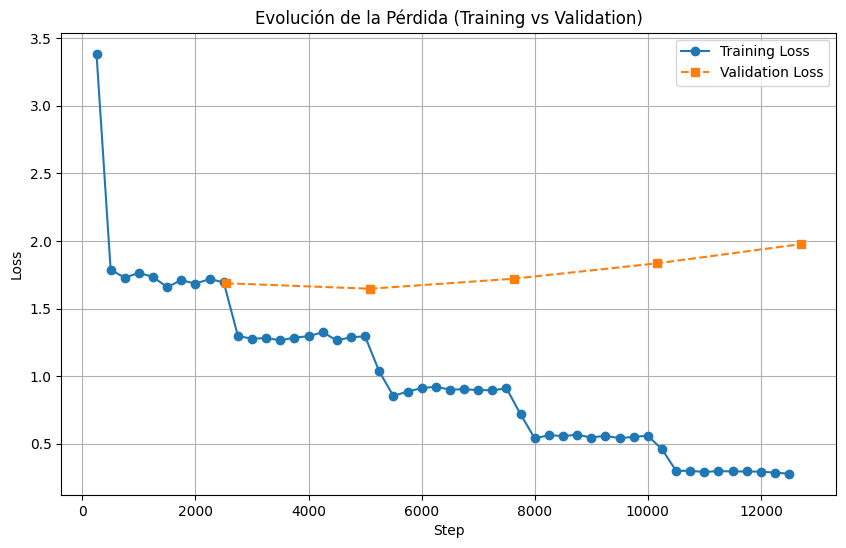

In [ ]:
# Evolución de la pérdida de training y validation
train_loss = df[["step", "loss"]].dropna()
eval_loss = df[["step", "eval_loss"]].dropna()

plt.figure(figsize=(10, 6))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", marker='o', linestyle='-')
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss", marker='s', linestyle='--')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolución de la Pérdida (Training vs Validation)")
plt.legend()
plt.grid()
plt.show()

Se observa que la pérdida de training disminuye al transcurrir el entrenamiento, lo que indica que está aprendiendo del conjunto de entrenamiento. Por otro lado, un aumento en la validation loss indica que no generaliza bien para nuevos datos. Esto se debe a que se tuvieron que usar una cantidad limitada de datos para el entrenamiento debido al los recursos disponibles.

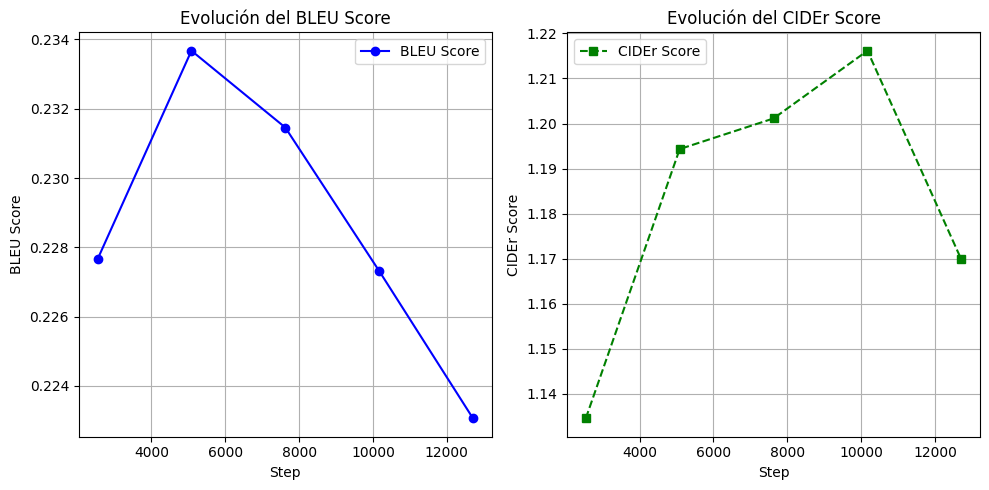

In [ ]:
metrics = df[["step", "eval_BLEU", "eval_CIDEr"]].dropna()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Gráfica de BLEU
axs[0].plot(metrics["step"], metrics["eval_BLEU"], label="BLEU Score", marker='o', linestyle='-', color='blue')
axs[0].set_title("Evolución del BLEU Score")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("BLEU Score")
axs[0].legend()
axs[0].grid()

# Gráfica de CIDEr
axs[1].plot(metrics["step"], metrics["eval_CIDEr"], label="CIDEr Score", marker='s', linestyle='--', color='green')
axs[1].set_title("Evolución del CIDEr Score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("CIDEr Score")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

Se observan la evolución de las métricas de BLEU y CIDEr según la cantidad de steps. Por un lado se observa que BLEU disminuye de los 5000 steps, mientras que CIDEr aumenta hasta alcanzar los 10000 steps y luego disminye un poco.

In [ ]:
with open('./results/test_results.json', 'r') as f:
    data = json.load(f)

df_test = pd.DataFrame(data, index=[1])

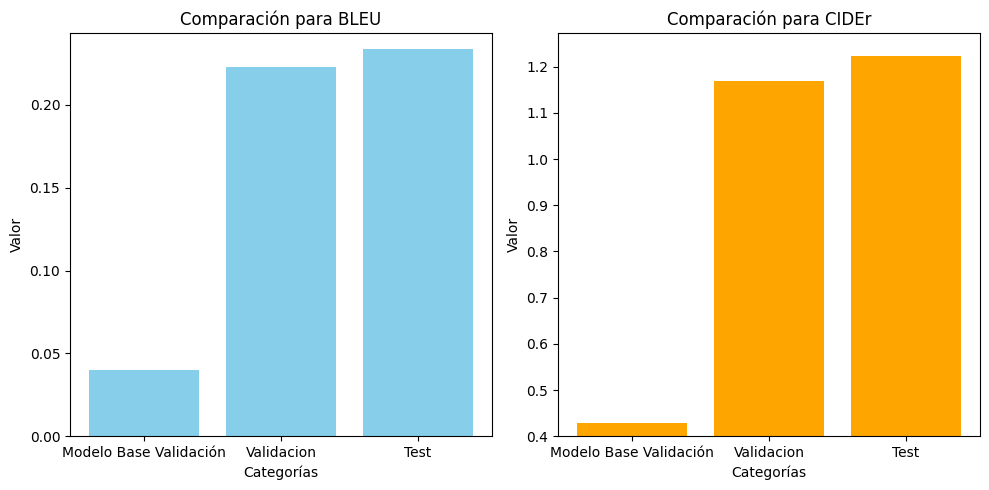

In [ ]:
Validacion_bleu = df["eval_BLEU"].dropna().iloc[-1]
Validacion_cider = df["eval_CIDEr"].dropna().iloc[-1]

test_bleu = df_test["eval_BLEU"].values[0]
test_cider = df_test["eval_CIDEr"].values[0]

# Organizar en un DataFrame
metrics_comparison = pd.DataFrame({
    "Metrics": ["BLEU", "CIDEr"],
    "Modelo Base Validación": [0.0401, 0.4285],
    "Validacion": [Validacion_bleu, Validacion_cider],
    "Test": [test_bleu, test_cider],
})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# BLEU
metrics_bleu = metrics_comparison[metrics_comparison["Metrics"] == "BLEU"]
axes[0].bar(metrics_bleu.columns[1:], metrics_bleu.values[0][1:], color='skyblue')
axes[0].set_title("Comparación para BLEU")
axes[0].set_ylabel("Valor")
axes[0].set_xlabel("Categorías")
axes[0].set_ylim(0, max(metrics_bleu.values[0][1:]) + 0.01)

# CIDEr
metrics_cider = metrics_comparison[metrics_comparison["Metrics"] == "CIDEr"]
axes[1].bar(metrics_cider.columns[1:], metrics_cider.values[0][1:], color='orange')
axes[1].set_title("Comparación para CIDEr")
axes[1].set_ylabel("Valor")
axes[1].set_xlabel("Categorías")
axes[1].set_ylim(0.4, max(metrics_cider.values[0][1:]) + 0.05)

plt.tight_layout()
plt.show()

Al realizar una comparación entre las métricas en validación test, se observa que se tuvieron valor ligeramente superiores para los datos de test, lo que indica que el modelo tiene una buena generalización para los datos de prueba. También se puede realizar una comparación de las métricas obtenidas con el modelo antes de entrenarlo, las cuales fueron para BLEU de 0.0401 y para CIDEr de 0.4279, por lo que al usar fine tuning estas mejoraron considerablemente.

## Generación de captions

In [12]:
model_dir = "./results/modelo"

try:
  processor = BlipProcessor.from_pretrained(model_dir)
  model = BlipForConditionalGeneration.from_pretrained(model_dir).to(device)
except OSError as e:
  print("Parece que no se encuentra el modelo en la ruta especificada.")
  user_response = input("¿Quieres descargar el modelo desde Hugging Face? (sí/no): ").strip().lower()

  if user_response in ['sí', 'si', 'yes', 'y']:
    model_dir_zip = "./results"
    url = 'https://drive.google.com/uc?export=download&id=1Hio124GdQnn1dleFEzo_Qf_T1qoHJxiS'
    zip_filename = 'modelo-entrenado.zip'

    gdown.download(url, zip_filename, quiet=False)
    print(f"Descomprimiendo '{zip_filename}' en '{model_dir_zip}'...")
    os.makedirs(model_dir_zip, exist_ok=True)
    with ZipFile_extrac(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(model_dir_zip)

    processor = BlipProcessor.from_pretrained(model_dir)
    model = BlipForConditionalGeneration.from_pretrained(model_dir).to(device)
  else:
    print("No se descargó el modelo.")

Parece que no se encuentra el modelo en la ruta especificada.
¿Quieres descargar el modelo desde Hugging Face? (sí/no): y


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Hio124GdQnn1dleFEzo_Qf_T1qoHJxiS
From (redirected): https://drive.google.com/uc?export=download&id=1Hio124GdQnn1dleFEzo_Qf_T1qoHJxiS&confirm=t&uuid=d9bc365a-36c7-4ae0-a245-f76b4465b211
To: /content/modelo-entrenado.zip
100%|██████████| 918M/918M [00:03<00:00, 242MB/s]


Descomprimiendo 'modelo-entrenado.zip' en './results'...


In [ ]:
def generate_attention_map(model, processor, raw_image, device="cuda"):
    """
    Genera un mapa de atención superpuesto sobre la imagen utilizando el modelo BLIP.

    Args:
        model: El modelo BLIP preentrenado.
        processor: El procesador del modelo BLIP.
        raw_image: La imagen de entrada en formato PIL.
        device: El dispositivo donde se cargará el modelo ('cuda' o 'cpu').

    Returns:
        cam_image: La imagen con el mapa de atención superpuesto.
    """
    inputs = processor(raw_image, return_tensors="pt").to(device)

    with torch.no_grad():
        vision_outputs = model.vision_model(**inputs, output_attentions=True)
        attentions = vision_outputs.attentions

    last_layer_attentions = attentions[-1]
    avg_attention = last_layer_attentions.mean(dim=1)

    cls_attention = avg_attention[:, 0, 1:]
    num_patches = cls_attention.shape[-1]

    grid_size = int(np.sqrt(num_patches))
    attention_map = cls_attention.cpu().numpy().reshape(grid_size, grid_size)
    attention_map = cv2.resize(attention_map, (raw_image.size[0], raw_image.size[1]))
    attention_map = attention_map - np.min(attention_map)
    attention_map = attention_map / np.max(attention_map)
    img_np = np.array(raw_image)

    # Aplicar el mapa de calor (heatmap)
    heatmap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    cam = heatmap + np.float32(img_np) / 255
    cam = cam / np.max(cam)
    cam_image = np.uint8(255 * cam)

    return cam_image

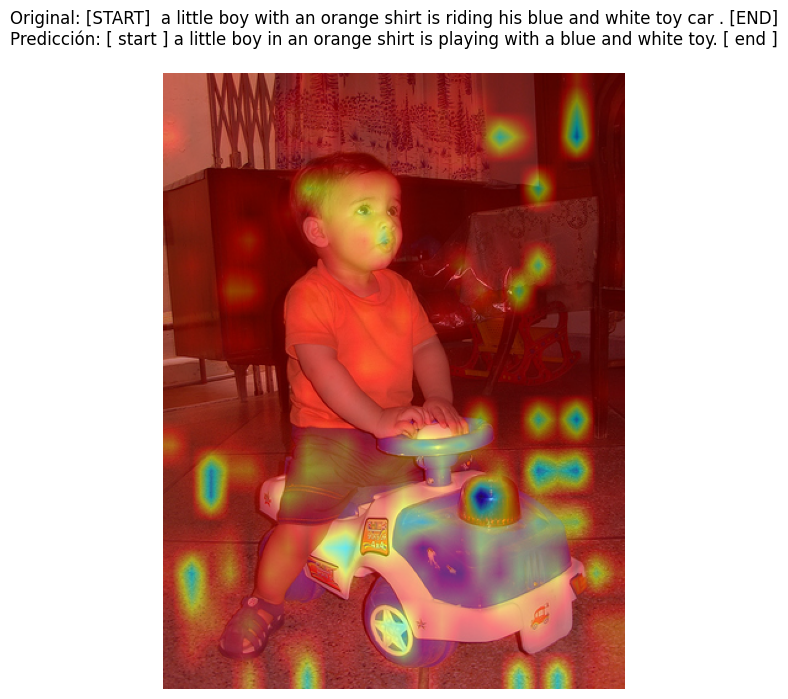

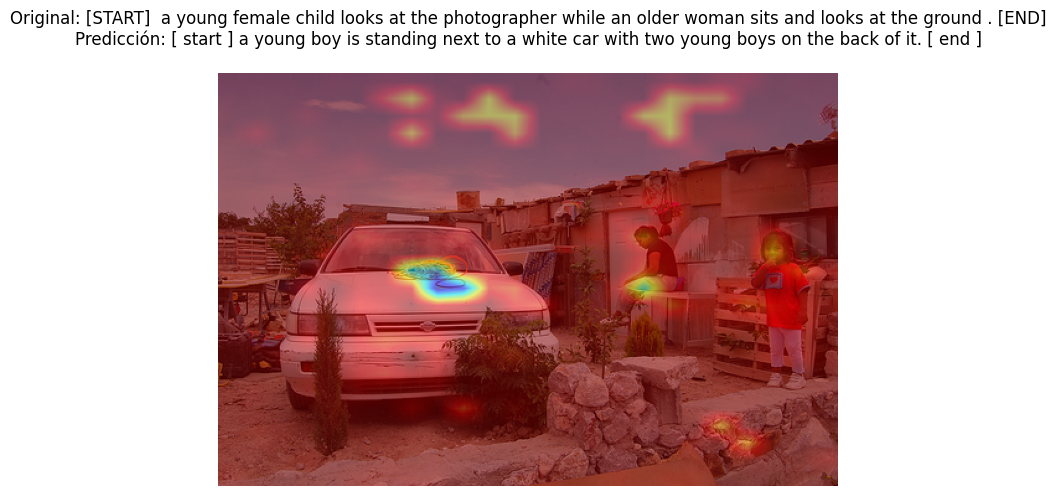

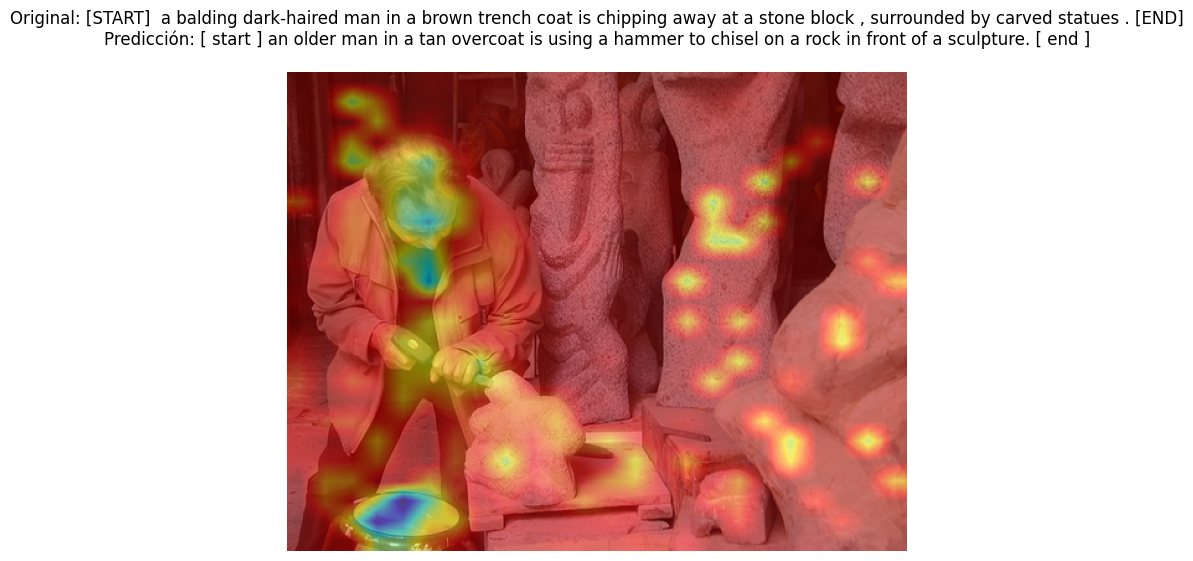

In [ ]:
image_test = test_df.head(3)

for index, row in image_test.iterrows():
    image_path = row['image_name']

    try:
        raw_image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error al abrir la imagen {image_path}: {e}")
        continue

    grad_image = generate_attention_map(model, processor, raw_image, device=device)
    caption = generate_caption(model, processor, raw_image)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(grad_image)
    ax.axis('off')
    plt.title(f"Original: {row['comment']}\nPredicción: {caption}", fontsize=12, pad=20)
    plt.show()

A continuación se van a realizar inferencias sobre imágenes que no estan presentes en el dataset.

In [13]:
url = 'https://drive.google.com/uc?export=download&id=19e63LnsRgQW8PN9WWnVsRjLQ5G81iVCO'
filename = 'trabajador.jpg'

if not os.path.exists(filename):
    try:
        gdown.download(url, filename, quiet=False)
        print(f"Descarga completada: {filename}")
    except Exception as e:
        print(f"Error durante la descarga: {e}")
else:
    print(f"El archivo '{filename}' ya existe. No se descargará nuevamente.")

Downloading...
From: https://drive.google.com/uc?export=download&id=19e63LnsRgQW8PN9WWnVsRjLQ5G81iVCO
To: /content/trabajador.jpg
100%|██████████| 106k/106k [00:00<00:00, 55.8MB/s]

Descarga completada: trabajador.jpg


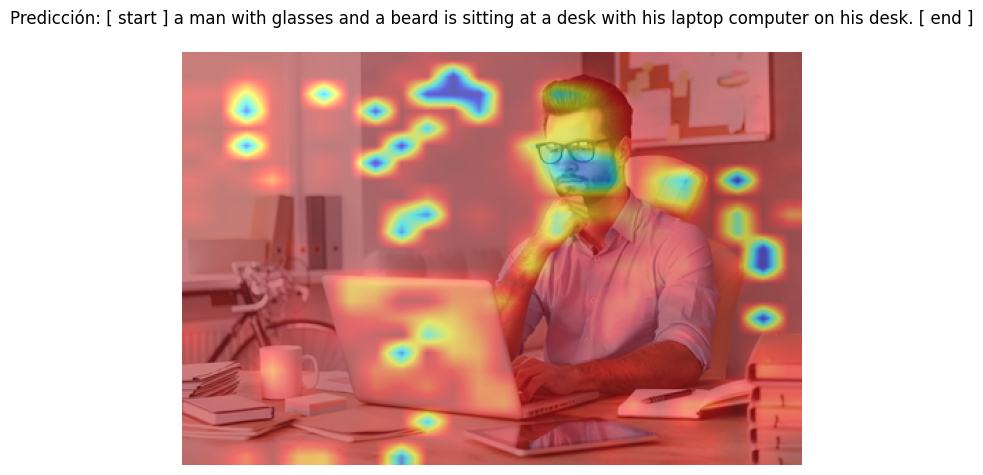

In [ ]:
try:
    raw_image = Image.open('./trabajador.jpg').convert("RGB")

    grad_image = generate_attention_map(model, processor, raw_image, device=device)
    caption = generate_caption(model, processor, raw_image)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(grad_image)
    ax.axis('off')
    plt.title(f"Predicción: {caption}", fontsize=12, pad=20)
    plt.show()
except Exception as e:
    print(f"Error al abrir la imagen {image_path}: {e}")